- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [2381]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import missingno as miss
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2382]:
df = pd.read_csv("train.csv")
df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [2383]:
df.drop("Id", axis = 1, inplace=True) 

In [2384]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Price  

Имеется 2 признака с пропусками. Посмотрим на распределение пропусков.

<AxesSubplot:>

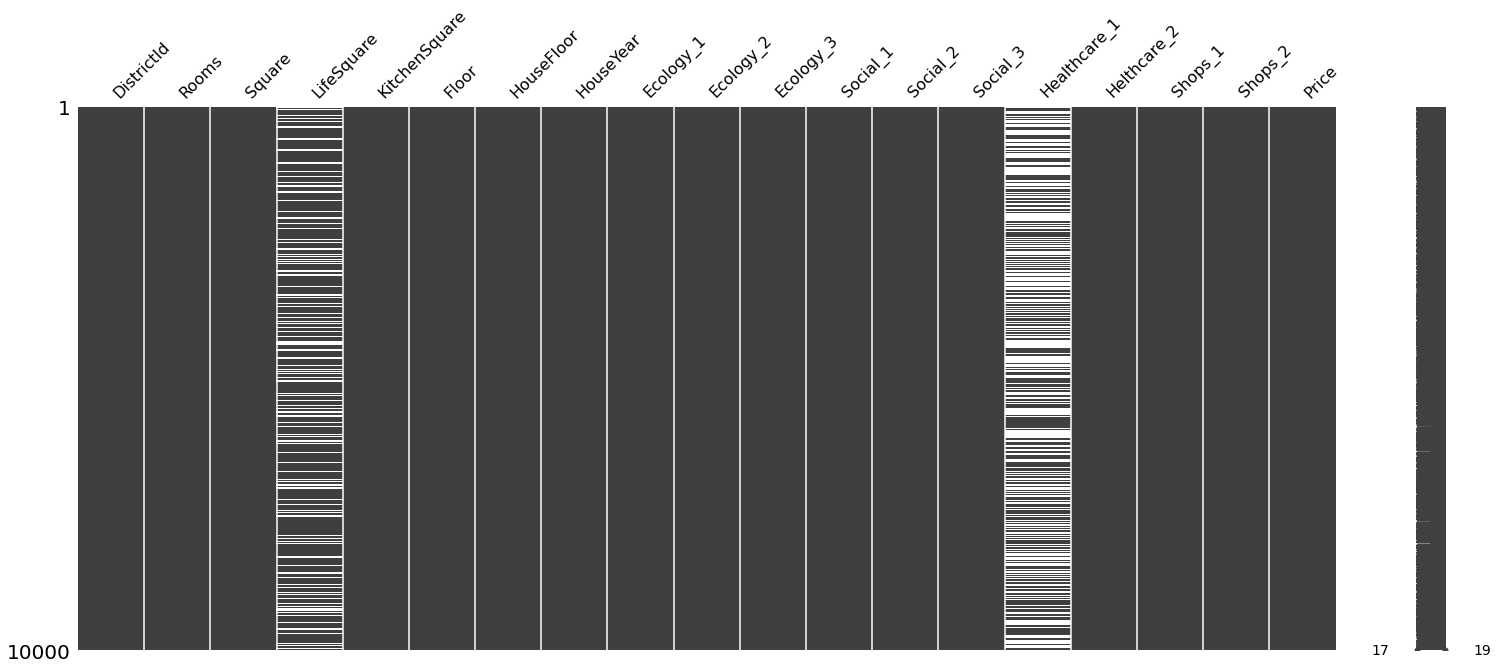

In [2385]:
miss.matrix(df)

Довольно равномерное распределение пропусков. Можно посмотреть, как пропуски распределены относительно других признаков.

<AxesSubplot:>

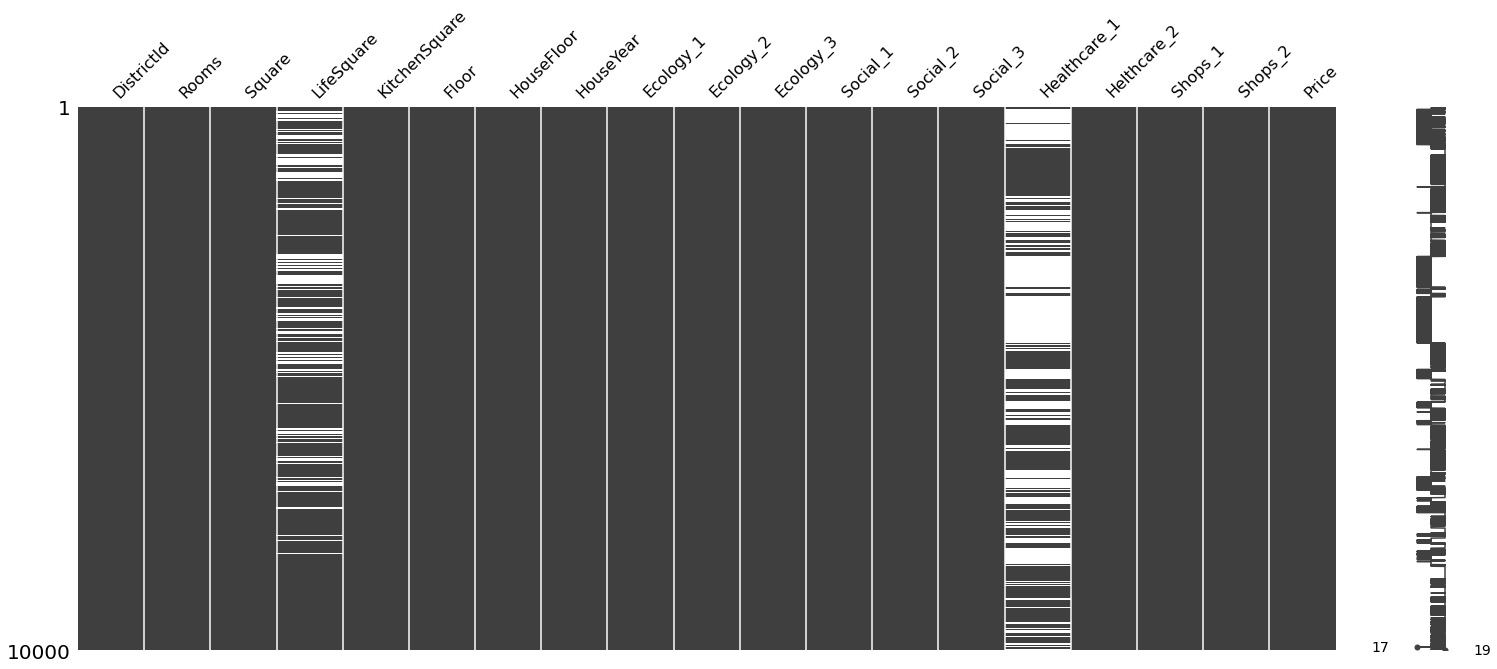

In [2386]:
miss.matrix(df.sort_values('DistrictId'))

Имеется явная закономерность по районам, если заполним средним или медианой, получим явное смещение. Однако возможно имеется связь между отствующими значениями и типом района. Оставлять такой признак с таким количеством пропусков не стоит, однако можно отметить его бинарным признаком Был пропуск\не было.

<AxesSubplot:>

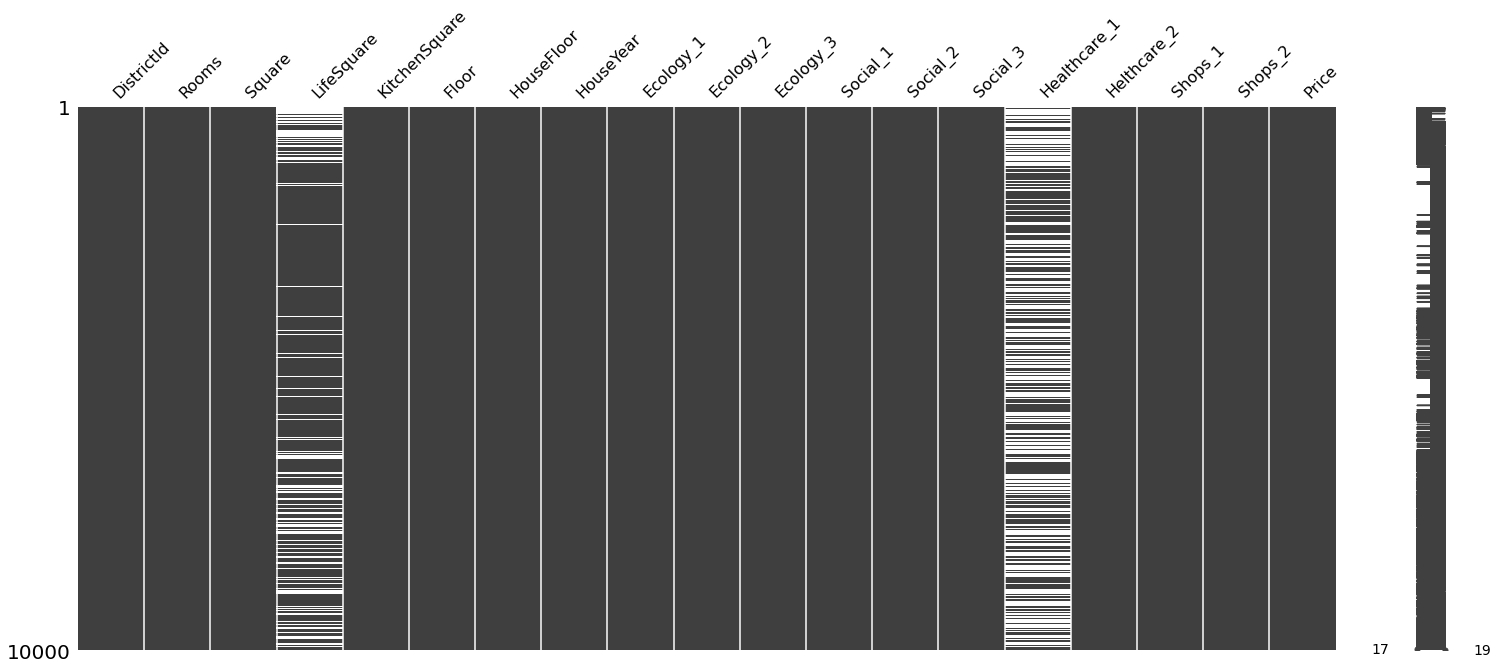

In [2387]:
miss.matrix(df.sort_values('HouseFloor'))

<AxesSubplot:>

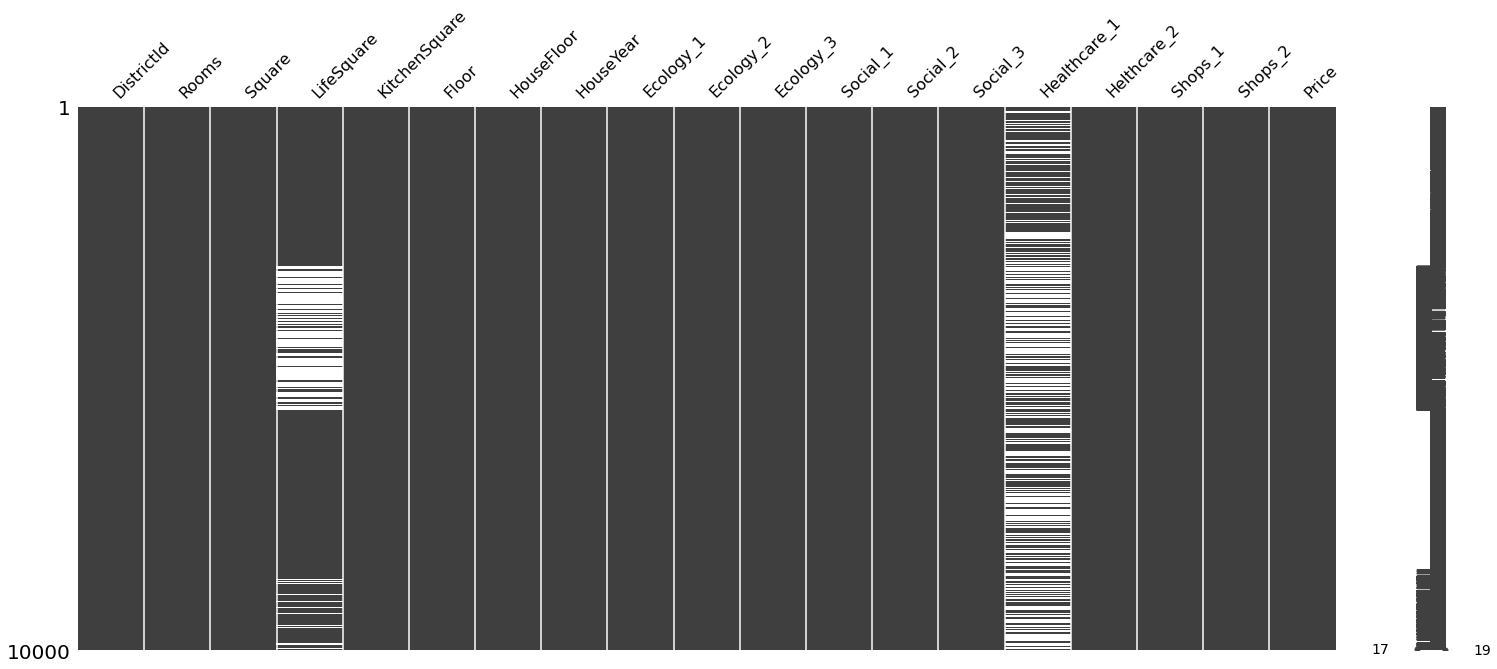

In [2388]:
miss.matrix(df.sort_values('HouseYear'))

Интересно, как складываются пропуски в LifeSquare относительно Года постройки здания. Возможно такое смещение стоит отметить доп признаком, разделив год постройки на интервалы.

И так. Имеется большой пробел в значениях признака __"Healthcare_1"__, заполнением медианными или средними значениями внесет дисбаланс в данные. Удалим его, но создадим доп признак о наличии пропусков.

In [2389]:
df["Healthcare_1_nan"] = 0
df.loc[df["Healthcare_1"].isnull(), "Healthcare_1_nan"] = 1

In [2390]:
df.drop("Healthcare_1", axis = 1, inplace=True)

__LifeSquare__ имеет более-менее равномерные пропуски, по этому заполнив например средним, это не вызовет большого смещения. Однако стоит рассмотреть теорию, что пропуски имеют логический смысл. Например это не жилое помещение в жилом доме (аппартаменты или помещение под магазин). Можно создать доп бинарный признак 1 - жилое помещение, 0 - не жилое помещение. И проверить имеет ли оно одинаковое распределение целевого признака.  

In [2391]:
df["islife"] = 1
df.loc[df["LifeSquare"].isnull(), "islife"] = 0
y1 = df[df["islife"] == 1]["Price"]
y2 = df[df["islife"] == 0]["Price"]

In [2392]:
stats.f_oneway(y1, y2)

F_onewayResult(statistic=386.28220448139905, pvalue=2.066839707320462e-84)

P-value очень маленький. Выходит в этом есть смысл, можно оставить метки а сами пропуски приравнять к медиане.

In [2393]:
df.loc[df["LifeSquare"].isnull(), "LifeSquare"] = df["LifeSquare"].median()


Посмотрим на статистики наших признаков.

In [2394]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Healthcare_1_nan,islife
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399,0.479800,0.788700
std,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865,0.499617,0.408251
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000
25%,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942,0.000000,1.000000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879,0.000000,1.000000
75%,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171,1.000000,1.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,1.000000,1.000000


__Rooms, Square, LifeSquare, KitchenSquare__ - Верхний порог очень высокий, вероятно имеются выбросы. Равно как и минимальные значения.

__DistrictId__ - хоть и численный признак, но таковым не является, стоит работать, как с категориальным.

__HouseFloor__ - слишком большое макс количество. Гугл говорит, что максимальная этажность небоскреба в мире 116.

__HouseYear__ - Стоит перевести в формат " сколько лет зданию" Также посмотреть максимальные значения, вероятно имеются записи с ГГММДД форматом, т.к. верхнее значение отличается на несколько порядков.

<AxesSubplot:xlabel='Square'>

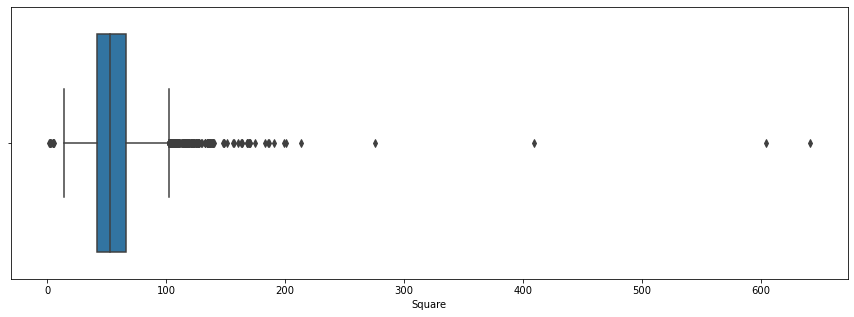

In [2395]:
plt.figure(figsize=(15, 5))
sns.boxplot(df["Square"])

#### Имеются выбросы. Будем отталкиваться от правила 3х Сигма (0.9973). Все что выходит за предел приравняем к медиане.

In [2396]:
max_square = np.quantile(df["Square"], q=0.99865)
min_square = np.quantile(df["Square"], q=0.00135)
outlier_square = (df["Square"] > max_square) | (df["Square"] < min_square)
df.loc[outlier_square, "Square"] = df["Square"].median()

<AxesSubplot:xlabel='LifeSquare'>

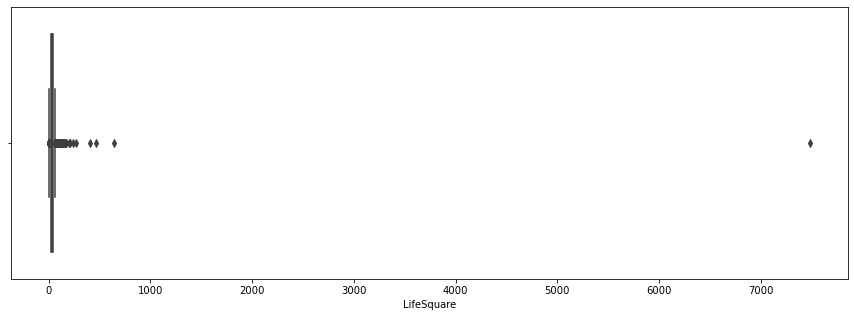

In [2397]:
plt.figure(figsize=(15, 5))
sns.boxplot(df["LifeSquare"])

#### Имеются выбросы. Будем отталкиваться от правила 3х Сигма (0.9973). Все что выходит за предел приравняем к медиане.

In [2398]:
max_square = np.quantile(df["LifeSquare"], q=0.99865)
min_square = np.quantile(df["LifeSquare"], q=0.00135)
outlier_square = (df["LifeSquare"] > max_square) | (df["LifeSquare"] < min_square)
df.loc[outlier_square, "LifeSquare"] = df["LifeSquare"].median()

<AxesSubplot:xlabel='KitchenSquare'>

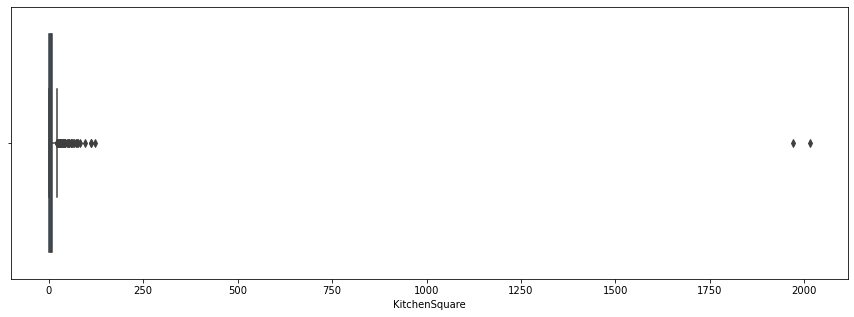

In [2399]:
plt.figure(figsize=(15, 5))
sns.boxplot(df["KitchenSquare"])

#### Имеются выбросы. Будем отталкиваться от правила 3х Сигма (0.9973). Все что выходит за предел приравняем к медиане.

In [2400]:
max_square = np.quantile(df["KitchenSquare"], q=0.99865)
min_square = np.quantile(df["KitchenSquare"], q=0.00135)
outlier_square = (df["KitchenSquare"] > max_square) | (df["KitchenSquare"] < min_square)
df.loc[outlier_square, "KitchenSquare"] = df["KitchenSquare"].median()

<AxesSubplot:xlabel='Rooms'>

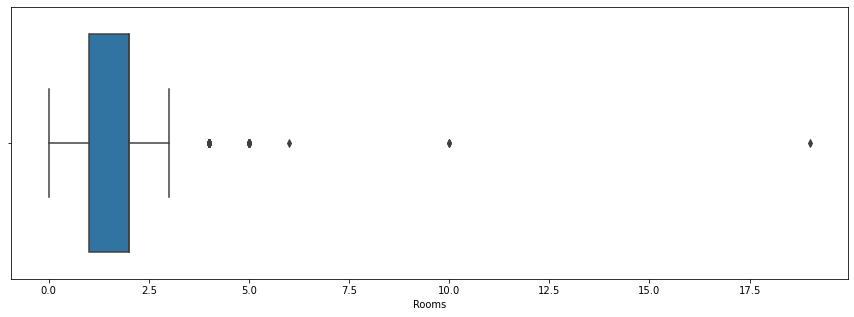

In [2401]:
plt.figure(figsize=(15, 5))
sns.boxplot(df["Rooms"])

#### Имеются выбросы. Будем отталкиваться от правила 3х Сигма (0.9973). Все что выходит за предел приравняем к медиане.

In [2402]:
max_square = np.quantile(df["Rooms"], q=0.99865)
min_square = np.quantile(df["Rooms"], q=0.00135)
outlier_square = (df["Rooms"] > max_square) | (df["Rooms"] < min_square)
df.loc[outlier_square, "Rooms"] = df["Rooms"].median()

<AxesSubplot:xlabel='HouseFloor'>

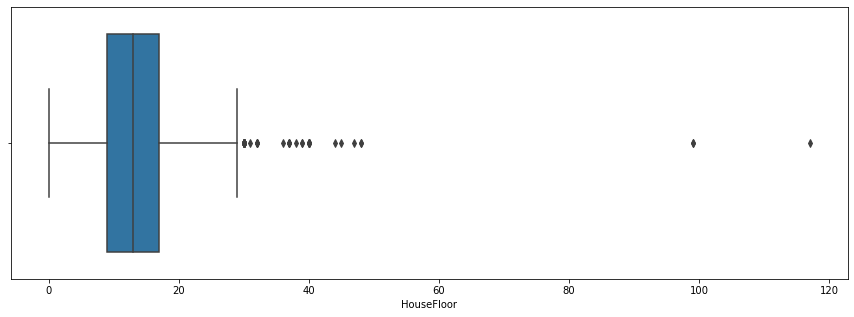

In [2403]:
plt.figure(figsize=(15, 5))
sns.boxplot(df["HouseFloor"])

#### Имеются выбросы. Будем отталкиваться от правила 3х Сигма (0.9973). Все что выходит за предел приравняем к медиане.

In [2404]:
max_square = np.quantile(df["HouseFloor"], q=0.99865)
min_square = np.quantile(df["HouseFloor"], q=0.00135)
outlier_square = (df["HouseFloor"] > max_square) | (df["HouseFloor"] < min_square)
df.loc[outlier_square, "HouseFloor"] = df["HouseFloor"].median()

Рассмотрим признак __DistrictId__, по своей сути он является категориальным признаком, хотя по факту численный. Надо как-то описать категории, например по средней цене квартиры в районе. ( В идеале, построить линейную регрессию без признака __DistrictId__, и взять среднюю ошибку по каждому району, добавить эту метрику вместо идрайона )

In [2405]:
distr = df.groupby(by="DistrictId")["Price"].mean().to_dict()
df.replace({"DistrictId": distr}, inplace=True )


Посмотрим и преобразуем __HouseYear__

<AxesSubplot:xlabel='HouseYear'>

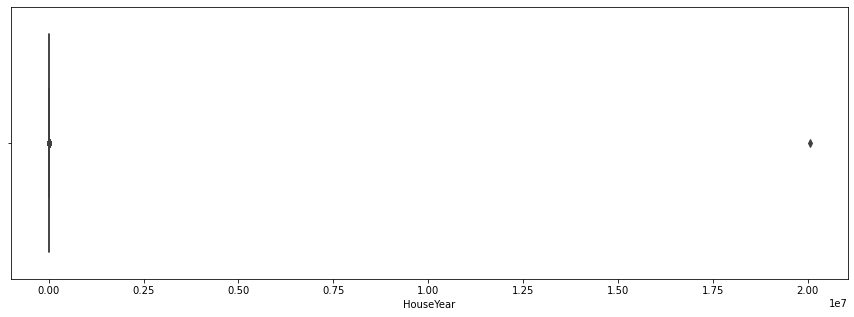

In [2406]:
plt.figure(figsize=(15, 5))
sns.boxplot(df["HouseYear"])

Пара выбросов, неверный формат. Преобразуем в ручную.

In [2407]:
df.loc[df["HouseYear"] > 2022, "HouseYear"] = df["HouseYear"].mode()[0]


Теперь преобразуем в возвраст дома.

In [2408]:
df["HouseYear"] = 2022 - df["HouseYear"]

In [2409]:
df["HouseYear"].describe()

count    10000.000000
mean        37.136200
std         18.409979
min          2.000000
25%         21.000000
50%         45.000000
75%         48.000000
max        112.000000
Name: HouseYear, dtype: float64

В таком представлении возвраст дома проще оценить.

### Посмотрим корреляции

<AxesSubplot:>

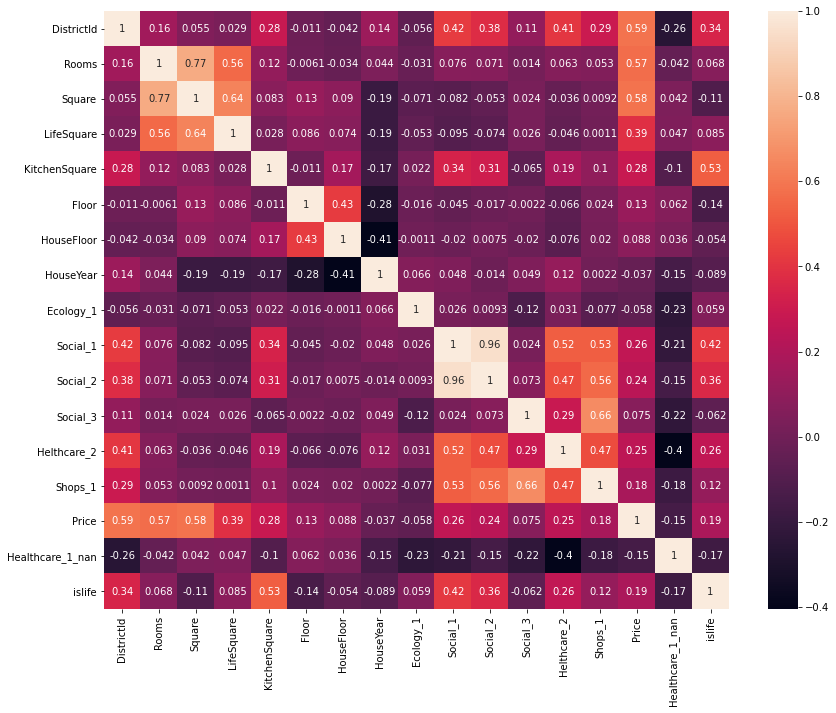

In [2410]:
plt.figure(figsize=(14, 11))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)


- Рассмотрим целевой признак Price. В целом достаточно слабые корреляции, самые большие корреляции между Rooms и Square. Стоит учесть, что корреляция между этими признаками тоже большая, и вероятнее всего логика такая, чем больше площадь, тем больше комнат. Т.е. площадь отпределяет количество комнат, а не на оборот, а значит корреляция комната\цена, случайна. 
- Social_2 и Social_1 имеют корреляцию между собой практически = 1, что может привести к мультиколиенарности, стоит удалить 1 признак.

#### Посомтрим ранговую корреляцию.

<AxesSubplot:>

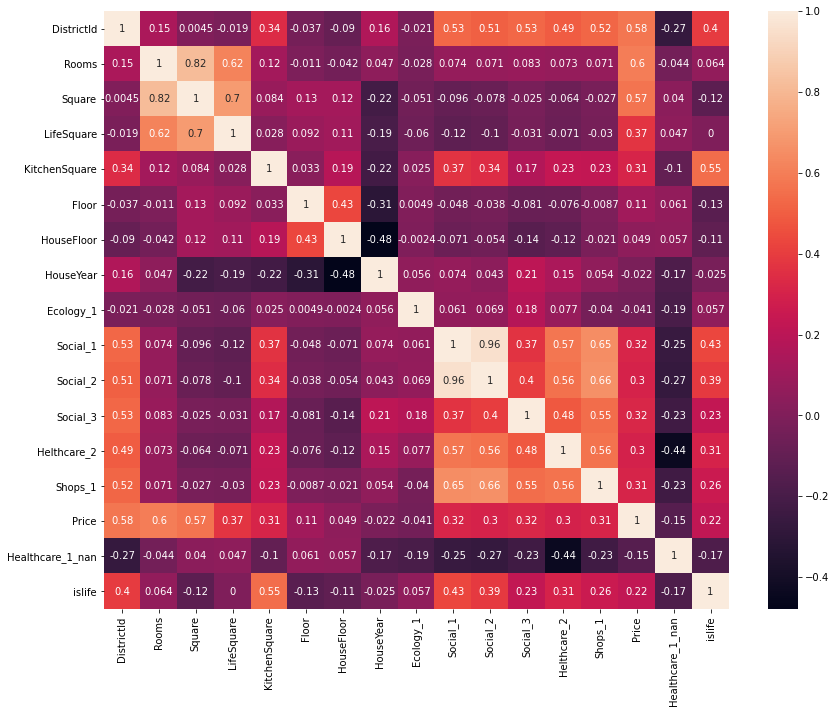

In [2411]:
plt.figure(figsize=(14, 11))
sns.heatmap(df.select_dtypes(include='number').corr(method="spearman"), annot=True)


 - В разрезе целевой переменной имеется разница по параметрам Social_1, Social_2, Social_3, Ecology_1, Shops, имеется не линейная связь. 

In [2412]:
df.drop("Social_2", axis = 1, inplace=True)


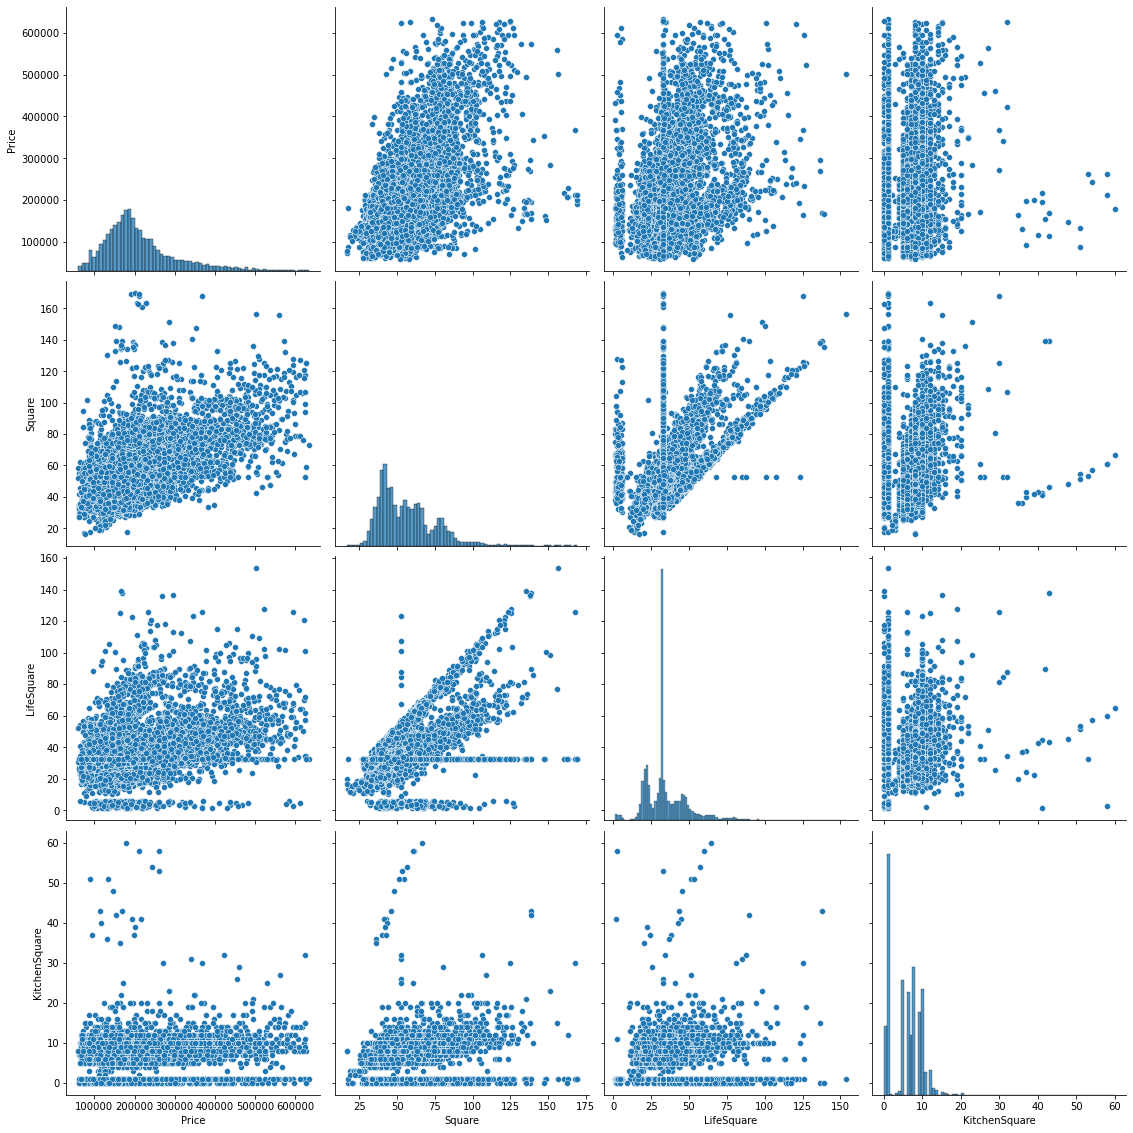

In [2413]:
sns.pairplot(df[["Price",  "Square", "LifeSquare", "KitchenSquare"]], height=4)

 - Распределение целевого признака похоже на нормальное, с длинным правым хвостом, что логично, т.к. существуют "элитные квартиры" которые стоят довольно дорого, но таких квартир всегда меньшинство, по сравнению со "стандартный потребитель". 
 - Имеются большие скопления вроде  "LifeSquare", "KitchenSquare" около нуля,  при этом разброс целевой переменной имеет стандартный диапазон. 
 - В целом видно несколько кластеров в распределении площадей.

Посомтрим на это скопление по ближе.

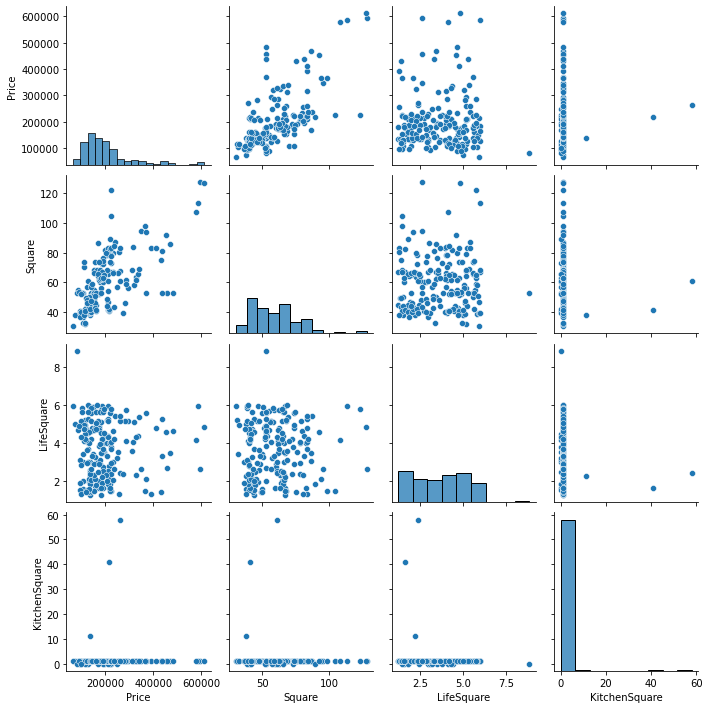

In [2414]:
sns.pairplot(df.loc[df["LifeSquare"] < 10][["Price",  "Square", "LifeSquare", "KitchenSquare"]])

- Похоже на какуюто аномалию, над которой нужно поработать, так как распределение цен и общей площади похоже на нормальное в этом кластере.

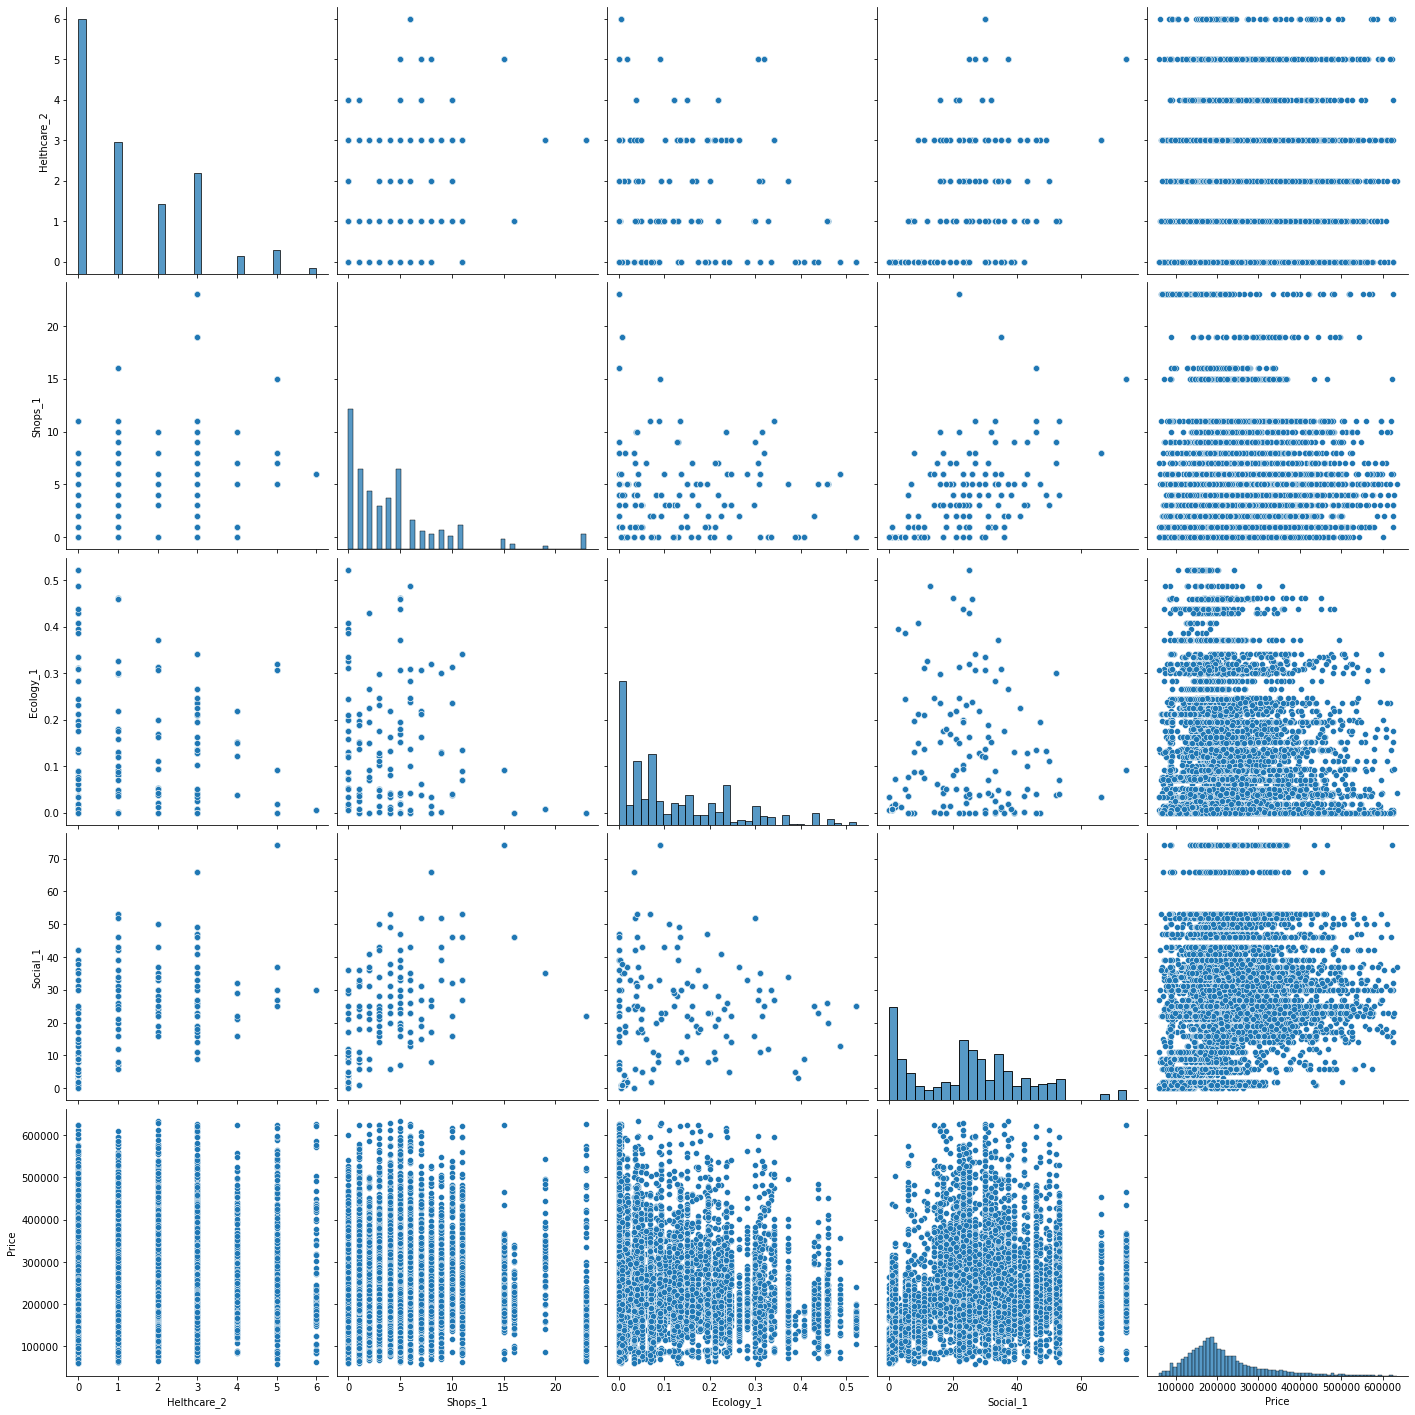

In [2415]:
sns.pairplot(df[["Helthcare_2", "Shops_1",  "Ecology_1", "Social_1", "Price"]], height=4)

- В целом видно зависимость между Social и Shops

### Посмотрим Категориальные переменные

In [2416]:
df.select_dtypes(exclude='number')

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B
...,...,...,...
9995,B,B,B
9996,B,B,A
9997,B,B,A
9998,B,A,B


In [2417]:
df.Ecology_2.unique()

array(['B', 'A'], dtype=object)

In [2418]:
df.Ecology_2.value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

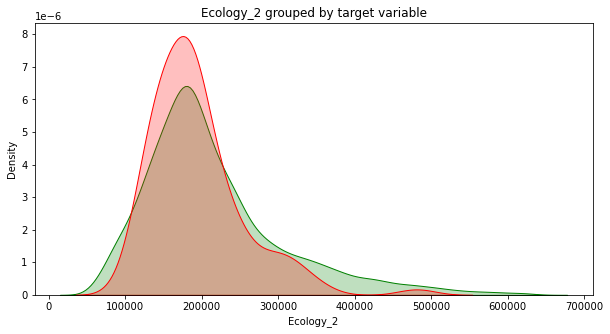

In [2449]:
eco_price = df[['Ecology_2', 'Price']]
eco_0_price = eco_price[eco_price['Ecology_2'] == 0]["Price"]
eco_1_price = eco_price[eco_price['Ecology_2'] == 1]["Price"]

plt.figure(figsize=(10, 5))

sns.kdeplot(eco_0_price, shade=True, label='0', color='g')
sns.kdeplot(eco_1_price, shade=True, label='1', color='r')

plt.xlabel('Ecology_2')
plt.title('Ecology_2 grouped by target variable')
plt.show()

- H0 - Разницы в распределнии Price между подкатегориями 'B', 'A' нет.
- H1 - Разница в распределнии Price между подкатегориями 'B', 'A' значима.
- alpha - 0.05

In [2419]:
y1 = df[df["Ecology_2"] == "B"]["Price"]
y2 = df[df["Ecology_2"] == "A"]["Price"]

In [2420]:
stats.f_oneway(y1, y2)

F_onewayResult(statistic=5.009677458089047, pvalue=0.025227927995423487)

#### p-value < alpha, принимаем теорию H1 - Разница в распределнии Price между подкатегориями 'B', 'A' значима.

In [2421]:
df.Ecology_3.unique()

array(['B', 'A'], dtype=object)

In [2422]:
df.Ecology_3.value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

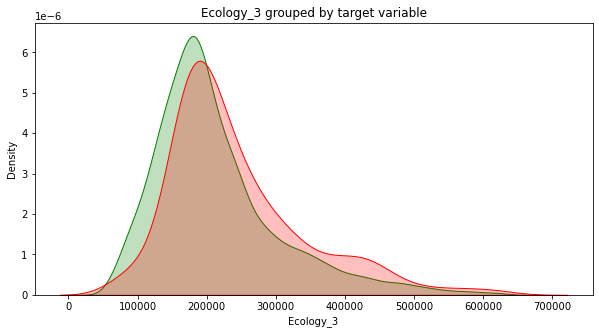

In [2450]:
eco_price = df[['Ecology_3', 'Price']]
eco_0_price = eco_price[eco_price['Ecology_3'] == 0]["Price"]
eco_1_price = eco_price[eco_price['Ecology_3'] == 1]["Price"]

plt.figure(figsize=(10, 5))

sns.kdeplot(eco_0_price, shade=True, label='0', color='g')
sns.kdeplot(eco_1_price, shade=True, label='1', color='r')

plt.xlabel('Ecology_3')
plt.title('Ecology_3 grouped by target variable')
plt.show()

- H0 - Разницы в распределнии Price между подкатегориями 'B', 'A' нет.
- H1 - Разница в распределнии Price между подкатегориями 'B', 'A' значима.
- alpha - 0.05

In [2423]:
y1 = df[df["Ecology_3"] == "B"]["Price"]
y2 = df[df["Ecology_3"] == "A"]["Price"]

In [2424]:
stats.f_oneway(y1, y2)

F_onewayResult(statistic=27.72325008286047, pvalue=1.428761770062292e-07)

#### p-value < alpha, принимаем теорию H1 - Разница в распределнии Price между подкатегориями 'B', 'A' значима.

In [2425]:
df.Shops_2.unique()

array(['B', 'A'], dtype=object)

In [2426]:
df.Shops_2.value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

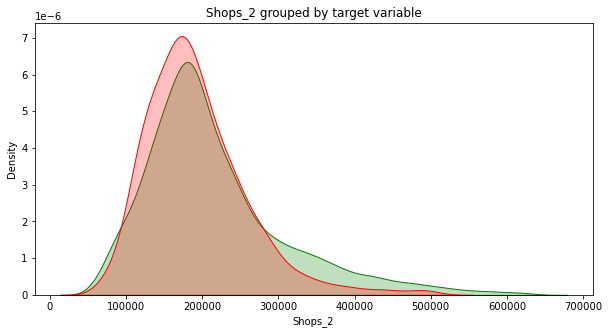

In [2451]:
eco_price = df[['Shops_2', 'Price']]
eco_0_price = eco_price[eco_price['Shops_2'] == 0]["Price"]
eco_1_price = eco_price[eco_price['Shops_2'] == 1]["Price"]

plt.figure(figsize=(10, 5))

sns.kdeplot(eco_0_price, shade=True, label='0', color='g')
sns.kdeplot(eco_1_price, shade=True, label='1', color='r')

plt.xlabel('Shops_2')
plt.title('Shops_2 grouped by target variable')
plt.show()

- H0 - Разницы в распределнии Price между подкатегориями 'B', 'A' нет.
- H1 - Разница в распределнии Price между подкатегориями 'B', 'A' значима.
- alpha - 0.05

In [2427]:
y1 = df[df["Shops_2"] == "B"]["Price"]
y2 = df[df["Shops_2"] == "A"]["Price"]

In [2428]:
stats.f_oneway(y1, y2)

F_onewayResult(statistic=49.781564533504095, pvalue=1.8325030438359957e-12)

#### p-value < alpha, принимаем теорию H1 - Разница в распределнии Price между подкатегориями 'B', 'A' значима.

In [2429]:
df['Ecology_2'] = (df['Ecology_2'] == 'A').astype(int)
df['Ecology_3'] = (df['Ecology_3'] == 'A').astype(int)
df['Shops_2'] = (df['Shops_2'] == 'A').astype(int) 

In [2430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DistrictId        10000 non-null  float64
 1   Rooms             10000 non-null  float64
 2   Square            10000 non-null  float64
 3   LifeSquare        10000 non-null  float64
 4   KitchenSquare     10000 non-null  float64
 5   Floor             10000 non-null  int64  
 6   HouseFloor        10000 non-null  float64
 7   HouseYear         10000 non-null  int64  
 8   Ecology_1         10000 non-null  float64
 9   Ecology_2         10000 non-null  int32  
 10  Ecology_3         10000 non-null  int32  
 11  Social_1          10000 non-null  int64  
 12  Social_3          10000 non-null  int64  
 13  Helthcare_2       10000 non-null  int64  
 14  Shops_1           10000 non-null  int64  
 15  Shops_2           10000 non-null  int32  
 16  Price             10000 non-null  float64

In [2431]:
X, y = df.drop(["Price"], axis = 1), df["Price"]


In [2432]:
lm = LinearRegression()

In [2433]:
lm.fit(X, y)

LinearRegression()

In [2434]:
predicts = lm.predict(X)

In [2435]:
r2_score(y, predicts)

0.6767849183269559

In [2436]:
X, y = df.drop(["Price", "DistrictId"], axis = 1), df["Price"]


In [2437]:
lm = LinearRegression()
lm.fit(X, y)
predicts = lm.predict(X)
r2_score(y, predicts)

0.5184106608824415

In [2438]:
e = y - predicts

In [2439]:
df["err"] = e

In [2440]:
distr = df.groupby(by="DistrictId")["err"].mean().to_dict()
df.replace({"DistrictId": distr}, inplace=True )

In [2441]:
X, y = df.drop(["Price", "err", "KitchenSquare", "LifeSquare" ], axis = 1), df["Price"]

In [2442]:
lm = LinearRegression()
lm.fit(X, y)
predicts = lm.predict(X)
r2_score(y, predicts)

0.6815898551247815